<a href="https://colab.research.google.com/github/jumbokh/nknu-class/blob/main/notebooks/Lab3_1b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3 Pokemon classification
https://www.kaggle.com/terminus7/pokemon-challenge

- Name：寶可夢名子
- Type 1：寶可夢的屬性
- Type 2：寶可夢的屬性(寶可夢可能擁有兩種屬性)
- HP：生命直
- Attack：攻擊力
- Defense：守備力
- Sp. Atk：特殊攻擊力
- Sp. Def：特殊防禦力
- Speed：速度
- Generation：進化階段
- Legendary：神獸 (1=神獸, 0=一般)

In [1]:
from google.colab import drive
drive.mount('/content/gdrive') # 點擊網址，選擇 Google 帳號登入，然後將授權碼貼回輸入框中

Mounted at /content/gdrive


In [2]:
!ln -fs /content/gdrive/My\ Drive/Tensorflow2/MMSLAB-TF2/ /app  #執行一次就可，否則會有錯誤訊息

In [3]:
%cd /app

/content/gdrive/My Drive/Tensorflow2/MMSLAB-TF2


In [4]:
!ls /app/pokemon-dataset

archive.zip  combats.gsheet  pokemon.gsheet  tests.gsheet
combats.csv  pokemon.csv     tests.csv


In [5]:
!tar -xzvf /app/cuDNN/cudnn-10.0-linux-x64-v7.5.0.56.tgz -C /usr/local/
!chmod a+r /usr/local/cuda/include/cudnn.h

# 檢查是否安裝成功
!cat /usr/local/cuda/include/cudnn.h | grep CUDNN_MAJOR -A 2

cuda/include/cudnn.h
cuda/NVIDIA_SLA_cuDNN_Support.txt
cuda/lib64/libcudnn.so
cuda/lib64/libcudnn.so.7
cuda/lib64/libcudnn.so.7.5.0
cuda/lib64/libcudnn_static.a
#define CUDNN_MAJOR 7
#define CUDNN_MINOR 5
#define CUDNN_PATCHLEVEL 0
--
#define CUDNN_VERSION (CUDNN_MAJOR * 1000 + CUDNN_MINOR * 100 + CUDNN_PATCHLEVEL)

#include "driver_types.h"


### Import

In [6]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

### 讀取數據並分析

讀取800隻寶可夢數據：

In [7]:
pokemon_df = pd.read_csv('/app/pokemon-dataset/pokemon.csv')  # 讀取寶可夢數據
pokemon_df.head()  # 顯示頭5比資料

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,1,False


將"#"數據設定為索引值：

In [8]:
pokemon_df= pokemon_df.set_index("#")  # 將索引設定為'#'列
pokemon_df.head()  # 顯示頭5比資料

,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
#,,,,,,,,,,,
1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
5,Charmander,Fire,NaN,39,52,43,60,50,65,1,False


讀取寶可夢對戰數據：

In [9]:
combats_df = pd.read_csv('/app/pokemon-dataset/combats.csv')  # 讀取對戰數據
combats_df.head()  # 顯示頭5比資料

,First_pokemon,Second_pokemon,Winner
0,266,298,298
1,702,701,701
2,191,668,668
3,237,683,683
4,151,231,151


### 補齊缺失 資料

檢查寶可夢數據是否有缺失資料：

In [10]:
pokemon_df.info()  # 顯示精靈寶可夢的數據資訊

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 1 to 800
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Name        799 non-null    object
 1   Type 1      800 non-null    object
 2   Type 2      414 non-null    object
 3   HP          800 non-null    int64 
 4   Attack      800 non-null    int64 
 5   Defense     800 non-null    int64 
 6   Sp. Atk     800 non-null    int64 
 7   Sp. Def     800 non-null    int64 
 8   Speed       800 non-null    int64 
 9   Generation  800 non-null    int64 
 10  Legendary   800 non-null    bool  
dtypes: bool(1), int64(7), object(3)
memory usage: 69.5+ KB


查看Type2每個類別的數量：

透過傳入參數dropna=False，可以將缺失數據（NaN）也考慮進去，NaN代表寶可夢並沒有第二種屬性。

In [11]:
pokemon_df["Type 2"].value_counts(dropna =False)

NaN         386
Flying       97
Ground       35
Poison       34
Psychic      33
Fighting     26
Grass        25
Fairy        23
Steel        22
Dark         20
Dragon       18
Ice          14
Ghost        14
Water        14
Rock         14
Fire         12
Electric      6
Normal        4
Bug           3
Name: Type 2, dtype: int64

填補缺失數據：使用empty將缺失的欄位填上。

In [12]:
pokemon_df["Type 2"].fillna('empty',inplace=True)
pokemon_df["Type 2"].value_counts()

empty       386
Flying       97
Ground       35
Poison       34
Psychic      33
Fighting     26
Grass        25
Fairy        23
Steel        22
Dark         20
Dragon       18
Water        14
Rock         14
Ice          14
Ghost        14
Fire         12
Electric      6
Normal        4
Bug           3
Name: Type 2, dtype: int64

### 數據前處理
檢查資料型態

In [13]:
print(combats_df.dtypes)  # 顯示對戰數據的資料型態
print('-' * 30)
print(pokemon_df.dtypes)  # 顯示寶可夢數據的資料型態

First_pokemon     int64
Second_pokemon    int64
Winner            int64
dtype: object
------------------------------
Name          object
Type 1        object
Type 2        object
HP             int64
Attack         int64
Defense        int64
Sp. Atk        int64
Sp. Def        int64
Speed          int64
Generation     int64
Legendary       bool
dtype: object


轉換數據格式

In [14]:
pokemon_df['Type 1'] = pokemon_df['Type 1'].astype('category')  # 將'Type 1'轉成category型態
pokemon_df['Type 2'] = pokemon_df['Type 2'].astype('category')  # 將'Type 2'轉成category型態
pokemon_df['Legendary'] = pokemon_df['Legendary'].astype('int')  # 將'Legendary'轉成int型態
pokemon_df.dtypes  # 顯示目前寶可用數據集資料型態

Name            object
Type 1        category
Type 2        category
HP               int64
Attack           int64
Defense          int64
Sp. Atk          int64
Sp. Def          int64
Speed            int64
Generation       int64
Legendary        int64
dtype: object

將寶可夢的Type1和Type2轉為One-hot Encoding表示：

In [15]:
df_type1_one_hot = pd.get_dummies(pokemon_df['Type 1'])  # 取得'Type 1'數據的One-hot編碼
df_type1_one_hot.head()  # 顯示頭5比資料

,Bug,Dark,Dragon,Electric,Fairy,Fighting,Fire,Flying,Ghost,Grass,Ground,Ice,Normal,Poison,Psychic,Rock,Steel,Water
#,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


使用Pandas的get_dummies函數，取得Type2（寶可夢第二種屬性）的One-hot Encoding：

In [16]:
df_type2_one_hot = pd.get_dummies(pokemon_df['Type 2'])  # 取得'Type 2'數據的One-hot編碼
df_type2_one_hot.head()  # 顯示頭5比資料

,Bug,Dark,Dragon,Electric,Fairy,Fighting,Fire,Flying,Ghost,Grass,Ground,Ice,Normal,Poison,Psychic,Rock,Steel,Water,empty
#,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


將兩組One-hot Encoding合併回數據集：

In [17]:
# 將上方兩個One-hot編碼資料加起來，將缺少的值補0，並轉呈int64型態
combine_df_one_hot = df_type1_one_hot.add(df_type2_one_hot, fill_value=0).astype('int64')
# 將顯示列數設定為30，不然會有部份資料無法顯示
pd.options.display.max_columns = 30
# 將One-hot編碼資料加到寶可夢數據中
pokemon_df = pokemon_df.join(combine_df_one_hot)
pokemon_df.head()  # 顯示頭5比資料

,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Bug,Dark,Dragon,Electric,Fairy,Fighting,Fire,Flying,Ghost,Grass,Ground,Ice,Normal,Poison,Psychic,Rock,Steel,Water,empty
#,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
5,Charmander,Fire,empty,39,52,43,60,50,65,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1


將寶可夢屬性轉為數值表示（0, 1, 2, …18）：透過cat.categories查詢類別的標籤。

In [18]:
dict(enumerate(pokemon_df['Type 2'].cat.categories))

{0: 'Bug',
 1: 'Dark',
 2: 'Dragon',
 3: 'Electric',
 4: 'Fairy',
 5: 'Fighting',
 6: 'Fire',
 7: 'Flying',
 8: 'Ghost',
 9: 'Grass',
 10: 'Ground',
 11: 'Ice',
 12: 'Normal',
 13: 'Poison',
 14: 'Psychic',
 15: 'Rock',
 16: 'Steel',
 17: 'Water',
 18: 'empty'}

透過cat.codes可以取得類別的編碼值。

In [19]:
pokemon_df['Type 2'].cat.codes.head(10)

#
1     13
2     13
3     13
4     13
5     18
6     18
7      7
8      2
9      7
10    18
dtype: int8

用數值表示（0, 1, 2…18）取代原本的標籤值：

In [20]:
pokemon_df['Type 1'] = pokemon_df['Type 1'].cat.codes
pokemon_df['Type 2'] = pokemon_df['Type 2'].cat.codes
pokemon_df.head()  # 顯示頭5比資料

,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Bug,Dark,Dragon,Electric,Fairy,Fighting,Fire,Flying,Ghost,Grass,Ground,Ice,Normal,Poison,Psychic,Rock,Steel,Water,empty
#,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,Bulbasaur,9,13,45,49,49,65,65,45,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
2,Ivysaur,9,13,60,62,63,80,80,60,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
3,Venusaur,9,13,80,82,83,100,100,80,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
4,Mega Venusaur,9,13,80,100,123,122,120,80,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
5,Charmander,6,18,39,52,43,60,50,65,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1


將沒有使用到的資料剔除（name）：

In [21]:
pokemon_df.drop('Name', axis='columns', inplace=True)
pokemon_df.head()  # 顯示頭5比資料

,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Bug,Dark,Dragon,Electric,Fairy,Fighting,Fire,Flying,Ghost,Grass,Ground,Ice,Normal,Poison,Psychic,Rock,Steel,Water,empty
#,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,9,13,45,49,49,65,65,45,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
2,9,13,60,62,63,80,80,60,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
3,9,13,80,82,83,100,100,80,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
4,9,13,80,100,123,122,120,80,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
5,6,18,39,52,43,60,50,65,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1


將寶可夢對戰數據中勝利方的表示改為0與1：

In [22]:
# apply方法第一個參數為自訂function,而axis為columns的話會將數據一行一
# 行放入function中處理，最後將所有結果組合成一個數據結構返回。
combats_df['Winner'] = combats_df.apply(lambda x: 0 
                                        if x.Winner == x.First_pokemon else 1, 
                                        axis='columns')
combats_df.head()  # 顯示頭5比資料

,First_pokemon,Second_pokemon,Winner
0,266,298,1
1,702,701,1
2,191,668,1
3,237,683,1
4,151,231,0


### 分割數據集
將數據集分為3個部份分別為：

- 訓練集
- 驗證集
- 測試集

In [23]:
data_num = combats_df.shape[0]
# 取得一筆與data數量相同的亂數索引，主要目的是用於打散資料
indexes = np.random.permutation(data_num)
# 並將亂數索引值分為Train、validation和test分為，這裡劃分比例為6:2:2
train_indexes = indexes[:int(data_num *0.6)]
val_indexes = indexes[int(data_num *0.6):int(data_num *0.8)]
test_indexes = indexes[int(data_num *0.8):]
# 透過上方的索引值從對戰數據中提取資料
train_data = combats_df.loc[train_indexes]
val_data = combats_df.loc[val_indexes]
test_data = combats_df.loc[test_indexes]

### Normalization 標準化

將數值表示的屬性除以19(因為加上empty共有19種屬性)，讓數值縮放置0~1之間。

In [24]:
pokemon_df['Type 1'] = pokemon_df['Type 1'] / 19
pokemon_df['Type 2'] = pokemon_df['Type 2'] / 19


使用Standard Score將生命值、攻擊力和防禦力等數值標準化。

In [25]:
mean = pokemon_df.loc[:, 'HP':'Generation'].mean()  # 計算平均值
std = pokemon_df.loc[:, 'HP':'Generation'].std()  # 計算標準差
# 標準化數據
pokemon_df.loc[:,'HP':'Generation'] = (pokemon_df.loc[:,'HP':'Generation']-mean)/std
pokemon_df.head()

,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Bug,Dark,Dragon,Electric,Fairy,Fighting,Fire,Flying,Ghost,Grass,Ground,Ice,Normal,Poison,Psychic,Rock,Steel,Water,empty
#,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.473684,0.684211,-0.950032,-0.924328,-0.796655,-0.238981,-0.248033,-0.801002,-1.398762,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
2,0.473684,0.684211,-0.362595,-0.523803,-0.347700,0.219422,0.290974,-0.284837,-1.398762,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
3,0.473684,0.684211,0.420654,0.092390,0.293665,0.830626,1.009651,0.403383,-1.398762,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
4,0.473684,0.684211,0.420654,0.646964,1.576395,1.502951,1.728328,0.403383,-1.398762,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
5,0.315789,0.947368,-1.185007,-0.831899,-0.989065,-0.391782,-0.787041,-0.112782,-1.398762,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1


### 建立Numpy array格式的訓練數據

準備對戰數據中每個寶可夢對應能力值的索引。

In [26]:
x_train_index = np.array(train_data.drop('Winner', axis='columns'))
x_val_index = np.array(val_data.drop('Winner', axis='columns'))
x_test_index = np.array(test_data.drop('Winner', axis='columns'))
print(x_train_index)

[[ 36 292]
 [699  25]
 [195 763]
 ...
 [425 732]
 [ 22 366]
 [677 330]]


準備訓練目標

In [27]:
y_train = np.array(train_data['Winner'])
y_val = np.array(val_data['Winner'])
y_test = np.array(test_data['Winner'])

準備兩種輸入數據：

第一種：寶可夢的屬性為數值表示。

In [28]:
# 取得寶可夢的能力值
pokemon_data_normal = np.array(pokemon_df.loc[:, :'Legendary'])
print(pokemon_data_normal.shape)
# 透過前面準備的索引產生輸入數據
x_train_normal = pokemon_data_normal[x_train_index -1].reshape((-1, 20))
x_val_normal = pokemon_data_normal[x_val_index -1].reshape((-1, 20))
x_test_normal = pokemon_data_normal[x_test_index -1].reshape((-1, 20))
print(x_train_normal.shape)

(800, 10)
(30000, 20)


第二種：寶可夢的屬性為One-hot encoding表示。

In [29]:
# 取得寶可夢的能力值
pokemon_data_one_hot = np.array(pokemon_df.loc[:, 'HP':])
print(pokemon_data_one_hot.shape)
# 透過前面準備的索引產生輸入數據
x_train_one_hot = pokemon_data_one_hot[x_train_index -1].reshape((-1, 54))
x_val_one_hot = pokemon_data_one_hot[x_val_index -1].reshape((-1, 54))
x_test_one_hot = pokemon_data_one_hot[x_test_index -1].reshape((-1, 54))
print(x_train_one_hot.shape)

(800, 27)
(30000, 54)


### 使用數值編碼訓練網路（Model 1）

In [30]:
inputs = keras.Input(shape=(20, ))  # 建立輸入層
# 加入全層全連接層，每一層輸出使用ReLU激活函數，並加上Dropout(每次丟棄30%)
x = layers.Dense(64, activation='relu')(inputs)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.3)(x)
# 最後一層全連接層，輸出維度類別數量，並且使用sigmoid激活函數
# outputs = layers.Dense(1, activation='sigmoid')(x)
outputs = layers.Dense(1)(x)


# 建立網路模型(將輸入到輸出所有經過的網路層連接起來)
model_1 = keras.Model(inputs, outputs, name='model-1')
model_1.summary()  # 顯示網路架構

Model: "model-1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20)]              0         
_________________________________________________________________
dense (Dense)                (None, 64)                1344      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0   

創建紀錄檔目錄

In [31]:
model_dir = '/app/lab3-logs/models'  # 設定儲存權重目錄
os.makedirs(model_dir)  # 創建儲存權重目錄

建立Callback function：

In [32]:
# 儲存訓練記錄檔
log_dir = os.path.join('/app/lab3-logs', 'model-1')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
# 儲存最好的網路模型權重
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-1.h5', 
                                             monitor='val_binary_accuracy', 
                                             save_best_only=True, 
                                             mode='max')

設定訓練使用的優化器、損失函數和指標函數

In [33]:
model_1.compile(keras.optimizers.Adam(),
               # loss=keras.losses.BinaryCrossentropy(), 
               loss=keras.losses.BinaryCrossentropy(from_logits=True), 
               metrics=[keras.metrics.BinaryAccuracy()])

訓練網路模型

In [34]:
history_1 = model_1.fit(x_train_normal, y_train, 
                batch_size=64 ,
                epochs=200, 
                validation_data=(x_val_normal, y_val),
                callbacks=[model_cbk, model_mckp])

Epoch 1/200
469/469 [==============================] - 6s 6ms/step - loss: 0.4137 - binary_accuracy: 0.8206 - val_loss: 0.2966 - val_binary_accuracy: 0.9046
Epoch 2/200
469/469 [==============================] - 2s 5ms/step - loss: 0.3065 - binary_accuracy: 0.8940 - val_loss: 0.2231 - val_binary_accuracy: 0.9195
Epoch 3/200
469/469 [==============================] - 2s 5ms/step - loss: 0.2585 - binary_accuracy: 0.9118 - val_loss: 0.1985 - val_binary_accuracy: 0.9347
Epoch 4/200
469/469 [==============================] - 3s 6ms/step - loss: 0.2271 - binary_accuracy: 0.9228 - val_loss: 0.1833 - val_binary_accuracy: 0.9345
Epoch 5/200
469/469 [==============================] - 2s 5ms/step - loss: 0.2196 - binary_accuracy: 0.9252 - val_loss: 0.1811 - val_binary_accuracy: 0.9389
Epoch 6/200
469/469 [==============================] - 3s 6ms/step - loss: 0.2046 - binary_accuracy: 0.9301 - val_loss: 0.1770 - val_binary_accuracy: 0.9368
Epoch 7/200
469/469 [==============================] - 2s 

### 使用One-hot編碼訓練網路（Model 2）

In [35]:
inputs = keras.Input(shape=(54, ))  # 建立輸入層
# 加入全層全連接層，每一層輸出使用ReLU激活函數，並加上Dropout(每次丟棄30%)
x = layers.Dense(64, activation='relu')(inputs)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.3)(x)
# 最後一層全連接層，輸出維度為類別數量，並且使用sigmoid激活函數
outputs = layers.Dense(1)(x)
# outputs = layers.Dense(1, activation='sigmoid')(x)

# 建立網路模型(將輸入到輸出所有經過的網路層連接起來)
model_2 = keras.Model(inputs, outputs, name='model-2')
model_2.summary()  # 顯示網路架構

Model: "model-2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 54)]              0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                3520      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0   

建立Callback function：

In [36]:
# 儲存訓練記錄檔
log_dir = os.path.join('/app/lab3-logs', 'model-2')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
# 儲存最好的網路模型權重
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-2.h5', 
                                         monitor='val_binary_accuracy', 
                                         save_best_only=True, 
                                         mode='max')

設定訓練使用的優化器、損失函數和指標函數

In [37]:
model_2.compile(keras.optimizers.Adam(), 
               # loss=keras.losses.BinaryCrossentropy(), 
               loss=keras.losses.BinaryCrossentropy(from_logits=True), 
               metrics=[keras.metrics.BinaryAccuracy()])

訓練網路模型

In [38]:
history_2 = model_2.fit(x_train_one_hot, y_train, 
                    batch_size=64 ,
                    epochs=200, 
                    validation_data=(x_val_one_hot, y_val), 
                    callbacks=[model_cbk, model_mckp])

Epoch 1/200
469/469 [==============================] - 4s 7ms/step - loss: 0.4257 - binary_accuracy: 0.8020 - val_loss: 0.3007 - val_binary_accuracy: 0.9047
Epoch 2/200
469/469 [==============================] - 2s 5ms/step - loss: 0.3127 - binary_accuracy: 0.8874 - val_loss: 0.2238 - val_binary_accuracy: 0.9251
Epoch 3/200
469/469 [==============================] - 3s 6ms/step - loss: 0.2590 - binary_accuracy: 0.9070 - val_loss: 0.1874 - val_binary_accuracy: 0.9279
Epoch 4/200
469/469 [==============================] - 2s 5ms/step - loss: 0.2283 - binary_accuracy: 0.9177 - val_loss: 0.1793 - val_binary_accuracy: 0.9273
Epoch 5/200
469/469 [==============================] - 2s 5ms/step - loss: 0.2084 - binary_accuracy: 0.9225 - val_loss: 0.1659 - val_binary_accuracy: 0.9329
Epoch 6/200
469/469 [==============================] - 2s 5ms/step - loss: 0.1970 - binary_accuracy: 0.9257 - val_loss: 0.1655 - val_binary_accuracy: 0.9334
Epoch 7/200
469/469 [==============================] - 2s 

### 比較兩種網路的訓練結果

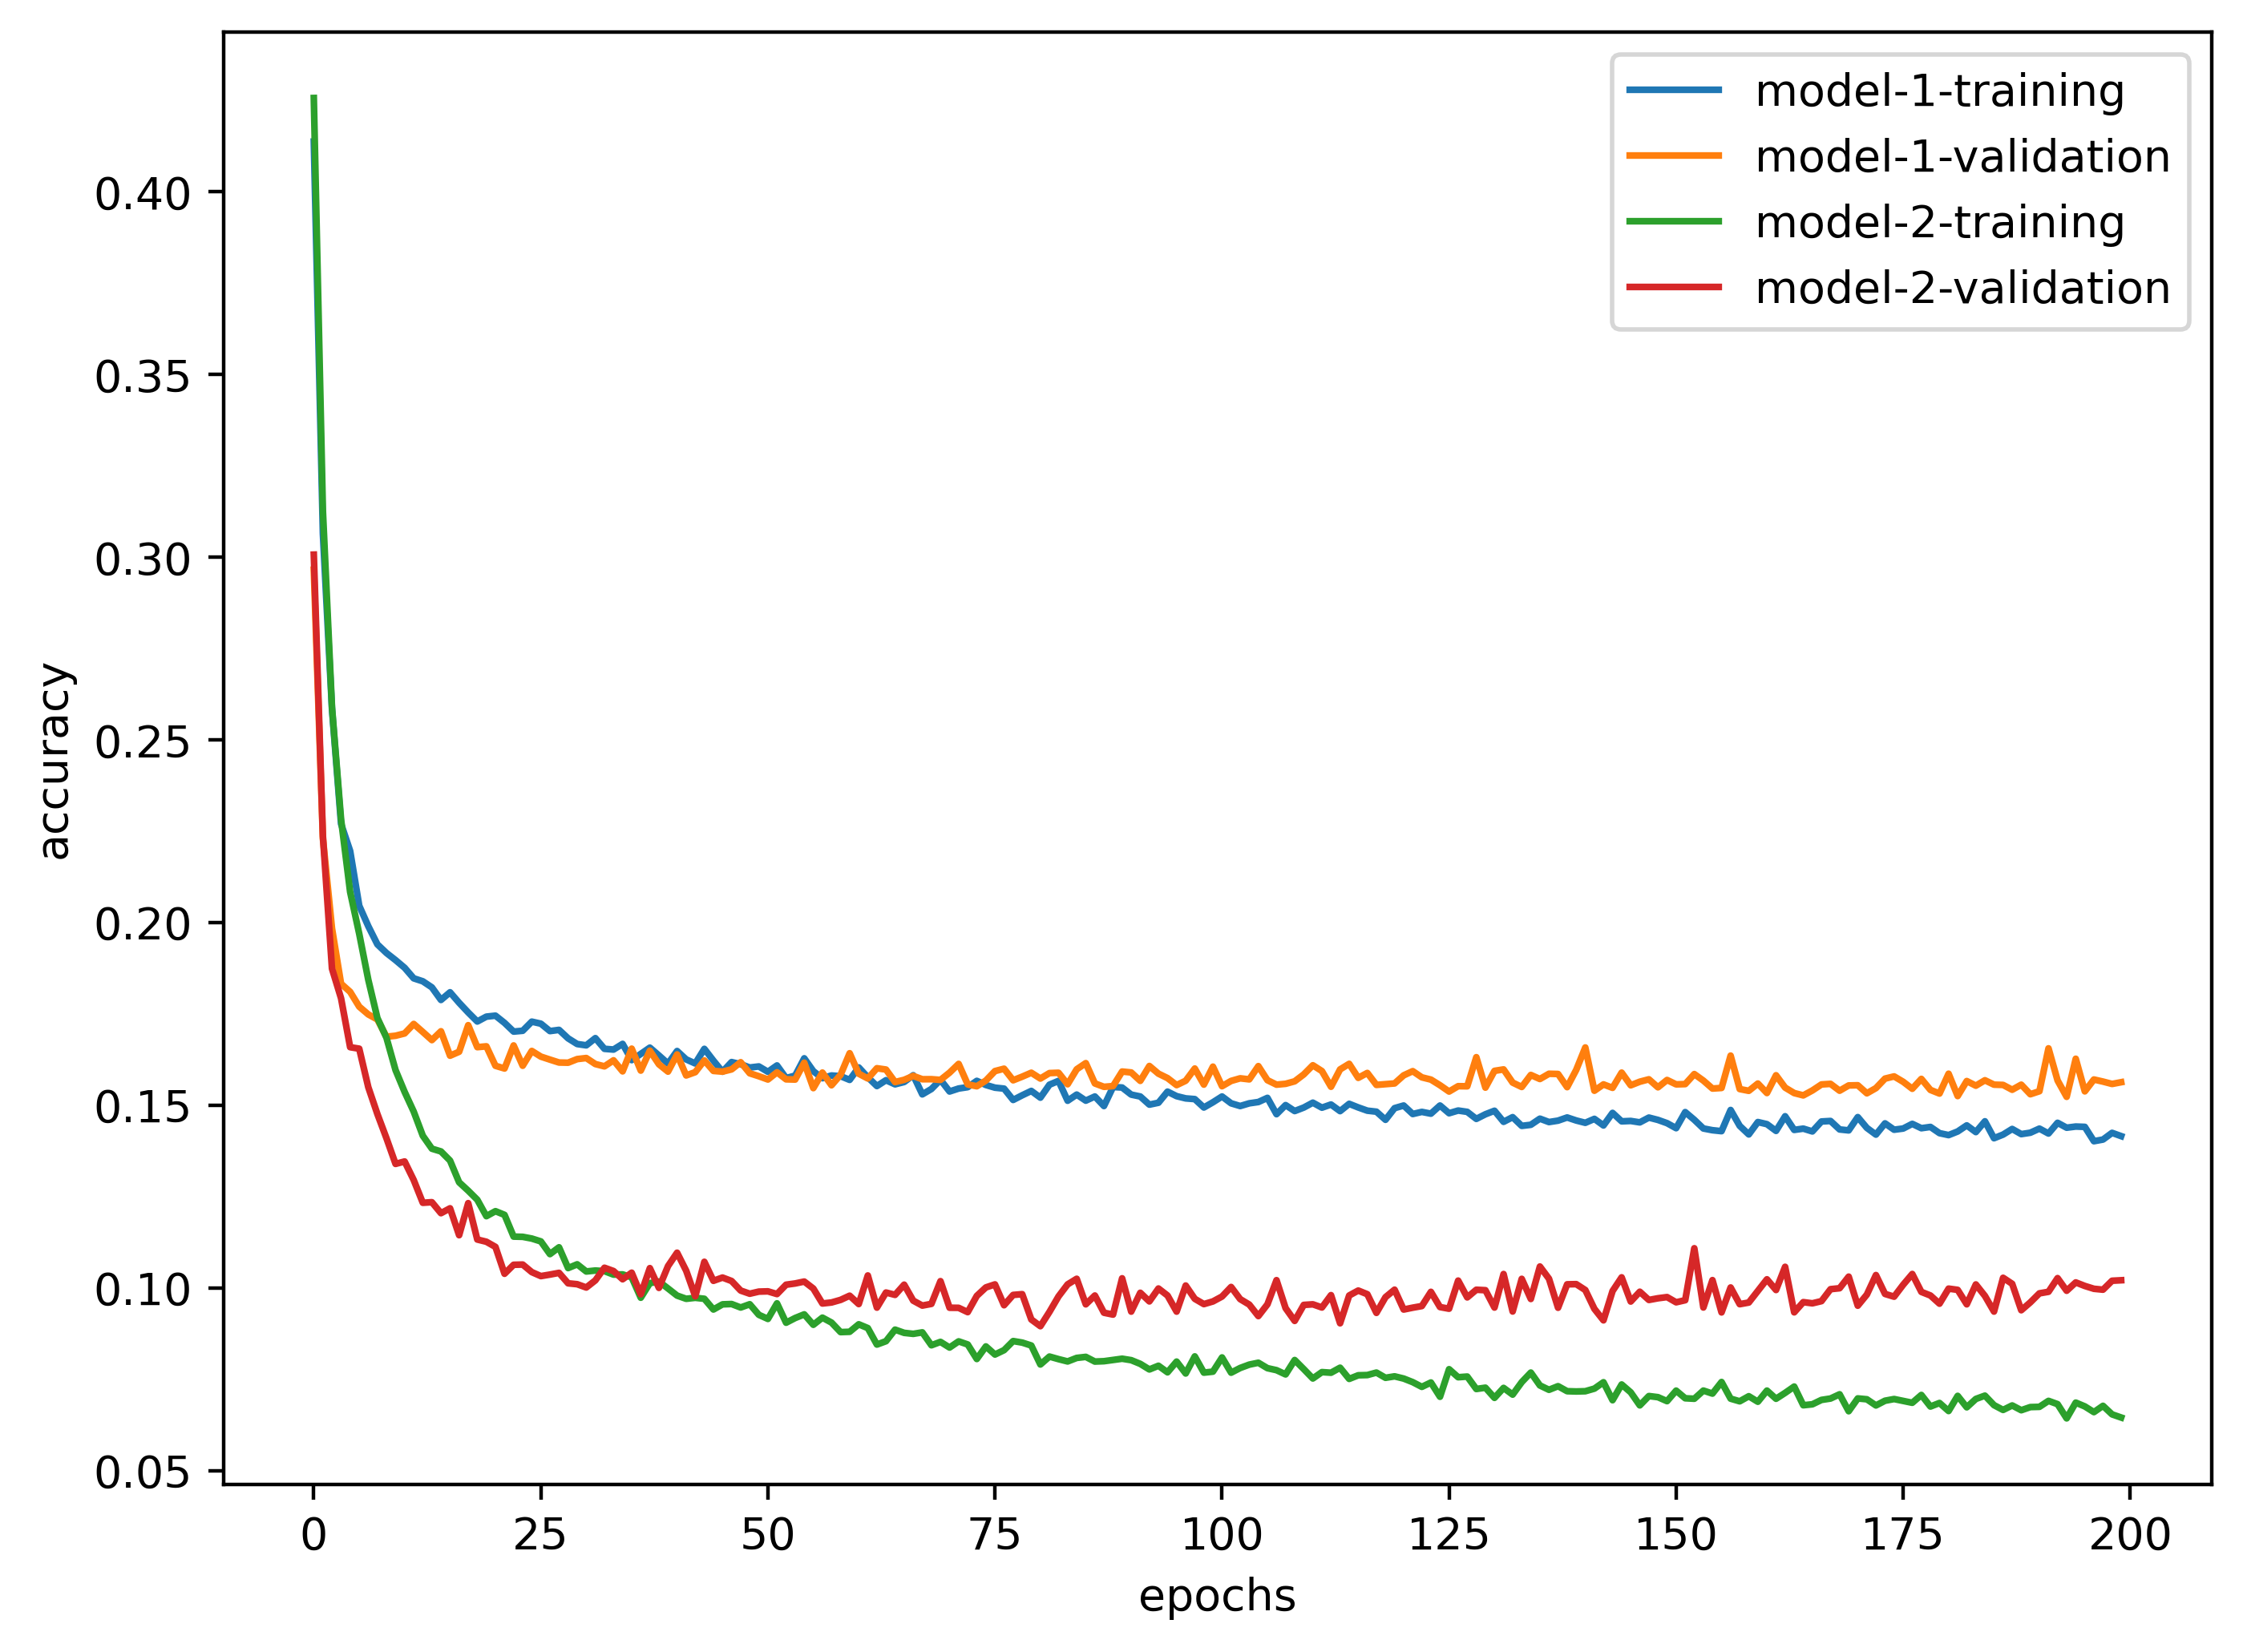

In [39]:
plt.figure(figsize=(8, 6), dpi=400)
plt.plot(history_1.history['loss'], label='model-1-training')
plt.plot(history_1.history['val_loss'], label='model-1-validation')
plt.plot(history_2.history['loss'], label='model-2-training')
plt.plot(history_2.history['val_loss'], label='model-2-validation')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()

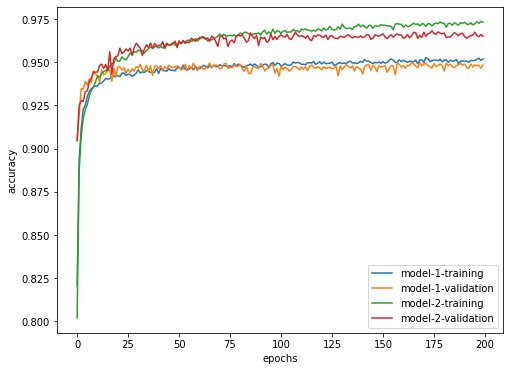

In [40]:
plt.figure(figsize=(8, 6))
plt.plot(history_1.history['binary_accuracy'], label='model-1-training')
plt.plot(history_1.history['val_binary_accuracy'], label='model-1-validation')
plt.plot(history_2.history['binary_accuracy'], label='model-2-training')
plt.plot(history_2.history['val_binary_accuracy'], label='model-2-validation')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()

驗證在測試集上

In [41]:
# 載入Model 1準確率最高的模型權重
model_1.load_weights(model_dir + '/Best-model-1.h5')
# 載入Model 2準確率最高的模型權重
model_2.load_weights(model_dir + '/Best-model-2.h5')
loss_1, accuracy_1 = model_1.evaluate(x_test_normal, y_test)
loss_2, accuracy_2 = model_2.evaluate(x_test_one_hot, y_test)
print("Model-1: {}%\nModel-2: {}%".format(accuracy_1, accuracy_2))

313/313 [==============================] - 1s 3ms/step - loss: 0.1121 - binary_accuracy: 0.9592
Model-1: 0.9470000267028809%
Model-2: 0.9592000246047974%


### 寶可夢PK

In [42]:
venusaur = np.expand_dims(pokemon_data_one_hot[3], axis=0)    # 妙蛙花
charizard = np.expand_dims(pokemon_data_one_hot[7], axis=0)   # 噴火龍
blastoise = np.expand_dims(pokemon_data_one_hot[12], axis=0)  # 水箭龜

In [43]:
# 妙蛙花 vs 噴火龍
pred = model_2.predict(np.concatenate([venusaur, charizard], axis=-1))
winner = '妙蛙花' if pred < 0 else '噴火龍'
print("pred={}, {} 獲勝".format(pred, winner))

# 噴火龍 vs 水箭龜
pred = model_2.predict(np.concatenate([charizard, blastoise], axis=-1))
winner = '噴火龍' if pred < 0 else '水箭龜'
print("pred={}, {} 獲勝".format(pred, winner))

# 水箭龜 vs 妙蛙花
pred = model_2.predict(np.concatenate([blastoise, venusaur], axis=-1))
winner = '水箭龜' if pred < 0 else '妙蛙花'
print("pred={}, {} 獲勝".format(pred, winner))

pred=[[11.751115]], 噴火龍 獲勝
pred=[[-9.380165]], 噴火龍 獲勝
pred=[[8.486103]], 妙蛙花 獲勝


In [44]:
!curl ipecho.net/plain

34.72.117.31

In [ ]:
!nvidia-smi -l

Wed Sep  8 02:17:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0    72W / 149W |    196MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------